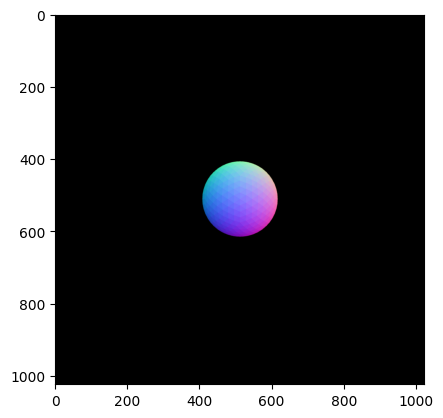

In [27]:
import imageio
from renderObj import renderNomral, loadAndScale
import pyrender
import trimesh
from pyrender.shader_program import ShaderProgramCache
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
r = pyrender.OffscreenRenderer(viewport_width=1024, viewport_height=1024)
plyPath = './testData/cow.obj'
r._renderer._program_cache = ShaderProgramCache(shader_dir="shaders")
camera_pose = np.array(
    [[ 1,  0,  0,  0],
     [ 0,  1, 0,   0],
     [ 0,  0,  1,  5],
     [ 0,  0,  0,  1]]
)

scene = pyrender.Scene(bg_color=(0, 0, 0))
scene.add(pyrender.Mesh.from_trimesh(trimesh.primitives.Sphere(), smooth = False))
camera = pyrender.PerspectiveCamera(yfov=np.pi / 2.0, aspectRatio=1.0, znear = 0.5, zfar = 40)
scene.add(camera, pose=camera_pose)
normals, depth = r.render(scene)
#normals,depth = renderNomral(r,loadAndScale(plyPath),r_angle=90)
plt.imshow(normals)

In [28]:
def compute_angle_with_vector(image, vector):
    # Convert the image to float32 for more precise computations
    image = image.astype(np.float32)
    image = image/127.5 - 1.0
    # Compute the norm of the input vector
    vector_norm = np.linalg.norm(vector)

    # Compute the norm of each pixel
    pixel_norms = np.linalg.norm(image, axis=-1, keepdims=True)

    # Compute the dot product of each pixel with the vector
    dot_products = np.sum(image*vector, axis=-1, keepdims=True)

    # Compute the cosines of the angles
    cosines = dot_products / (pixel_norms * vector_norm)

    # Clip values to the valid range for arccos, i.e., [-1, 1]
    cosines = np.clip(cosines, -1, 1)

    # Compute the angles in degrees
    angles = np.degrees(np.arccos(cosines))

    # Normalize angles to grayscale

    return angles

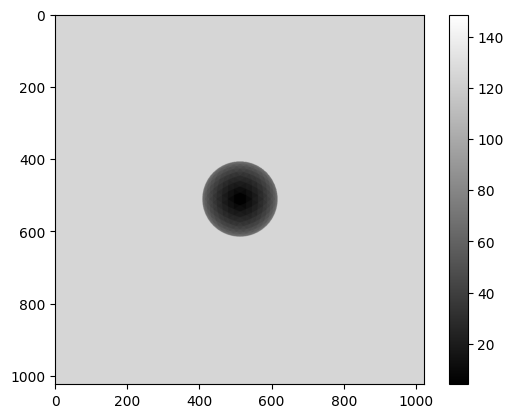

In [29]:
vectormap = compute_angle_with_vector(normals,np.array([0,0,1]))
plt.imshow(vectormap,cmap="gray")
plt.colorbar()

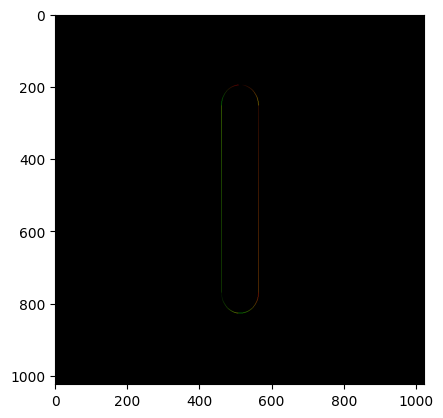

In [180]:
plt.imshow(vectormap)

In [181]:
def draw_vector_on_blank(vectormap, scale=0.5):
    # 创建一个空的RGB图像
    blank_image = np.zeros((*vectormap.shape[0:2], 3), dtype=np.uint8)

    # 遍历图像的每个像素
    for y in range(vectormap.shape[0]):
        for x in range(vectormap.shape[1]):
            vector = vectormap[y, x]

            # 如果向量不是零向量，就在图像上绘制箭头
            if np.any(vector):
                # 根据RGB值计算向量的方向和长度
                dx, dy, _ = vector
                dx *= scale
                dy *= scale

                # 绘制箭头
                end_point = (int(x + dx), int(y + dy))
                cv2.arrowedLine(blank_image, (x, y), end_point, (0, 255, 0), 1)

    return blank_image

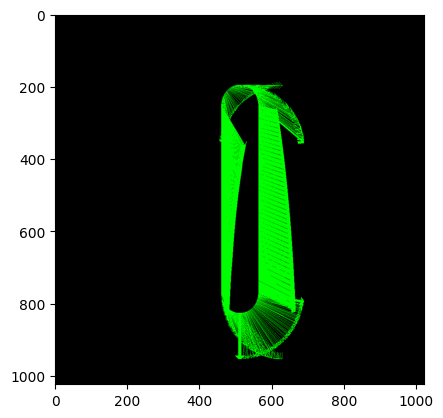

In [182]:
vectors = draw_vector_on_blank(vectormap)
plt.imshow(vectors)